# Evaluations for maximum likelihood

## 1. Actual data likelihood
## 2. Amari distance

In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [2]:
key = jax.random.PRNGKey(1)

## Generate data

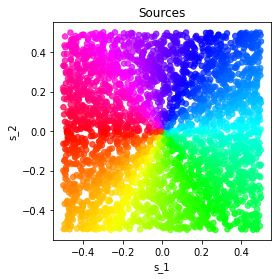

In [3]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

S -= 0.5


from plotting import cart2pol, scatterplot_variables

_, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

In [4]:
# from mixing_functions import build_conformal_map
# nonlinearity = lambda x : jnp.exp(1.3*x)
# mixing, mixing_gridplot = build_conformal_map(nonlinearity)

from mixing_functions import build_moebius_transform

# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy

angle = 45
theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
A = np.array([[c, -s], [s, c]])
# A = ortho_group.rvs(dim=D)
# A =np.array([[-0.98601346, -0.16666568],
#        [-0.16666568,  0.98601346]])

# Scalar
alpha = 3.5
# Two vectors with data dimensionality
a = np.array([2.1, 2.5]) #2.0 * np.ones(D) # a vector in \RR^D
b = 3.0 * np.ones(D) # a vector in \RR^D
epsilon = 2

from jax import vmap
mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b, epsilon=epsilon)
mixing_batched = vmap(mixing_moebius)

from jax import vmap

mixing_batched = vmap(mixing_moebius)

In [5]:
A

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [6]:
# X = S @ A

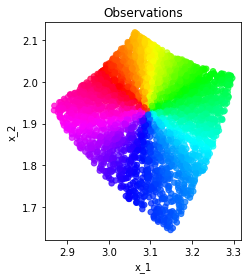

In [7]:
X = mixing_batched(S)
# X -= jnp.mean(X, axis=0)
# X /= jnp.std(X, axis=0)

scatterplot_variables(X, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

In [8]:
unmixing_batched = vmap(unmixing_moebius)

In [9]:
Y = unmixing_batched(X)

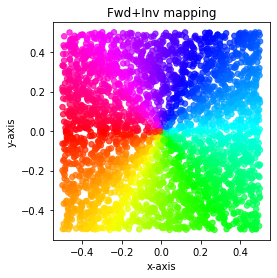

In [10]:
scatterplot_variables(Y, 'Fwd+Inv mapping', colors=colors, savefig=False)#True, fname="observations_flow")

## 1. Compute the true data likelihood

In [11]:
from metrics import observed_data_likelihood

In [12]:
jac_unmixing = jax.vmap(jax.jacfwd(unmixing_moebius))

In [13]:
# observed_data_likelihood(X[0], unmixing_moebius)

In [14]:
# observed_likelihood_batched = vmap(lambda y: observed_data_likelihood(y, unmixing_moebius))

In [15]:
obs_likel = observed_data_likelihood(X, jac_unmixing)

In [16]:
jnp.mean(obs_likel)

DeviceArray(2.2265003, dtype=float32)

## Set up model

In [17]:
n_layers = 10 #32
hidden_units = [40, 40] #[128, 128]

# I would substitute the Normal with a Logistic distribution

def log_prob(x):
    base_dist = distrax.Independent(distrax.Logistic(loc=jnp.zeros(2), scale=jnp.ones(2)),
                                                    reinterpreted_batch_ndims=1)
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    model = distrax.Transformed(base_dist, flows)
    return model.log_prob(x)

In [18]:
# Init model
logp = hk.transform(log_prob)
params = logp.init(key, jnp.array(np.random.randn(5, 2)))

In [19]:
# In ML + C_IMA, we don't want triangular Jacobian! I comment out the below

# Make triangular
# masks = masks_triangular_weights([h // 2 for h in hidden_units])
# params = make_weights_triangular(params, masks)

In [20]:
# This is one part of the loss!
# Copied over from the triangular_residual_flow_test notebook

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)

inv_map = hk.transform(inv_map_fn)

jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))



In [21]:
from metrics import cima, cima_higher_d

In [22]:
# Apply spectral normalization

uv = spectral_norm_init(params, key)
params, uv = spectral_normalization(params, uv)

In [23]:
# Define a Lagrange multiplier to be multiplied before the c_ima contrast
lag_mult = 1.0

def loss(params, x):
    ll = logp.apply(params, None, x)
    # Compute the Jacobian based on current parameters
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
    # Compute C_IMA based on current Jacobian
    c_ima = cima(x, jac_fn)
#     c_ima = cima_higher_d(x, jac_fn)
    return -jnp.mean(ll) + lag_mult * jnp.mean(c_ima)

Model training

In [24]:
opt_init, opt_update, get_params = adam(step_size=1e-3)

@jax.jit
def step(it, opt_state, uv, x):
    params = get_params(opt_state)
#     params = make_weights_triangular(params, masks) # makes Jacobian triangular
    params, uv = spectral_normalization(params, uv)
    params_flat = jax.tree_util.tree_flatten(params)[0]
    for ind in range(len(params_flat)):
        opt_state.packed_state[ind][0] = params_flat[ind]
    value, grads = jax.value_and_grad(loss, 0)(params, x)
    opt_out = opt_update(it, grads, opt_state)
    return value, opt_out, uv

In [25]:
iters, batch_size = 50000, 256

opt_state = opt_init(params)

loss_hist = np.array([])

In [26]:
for i in range(iters):
    x = X[np.random.choice(X.shape[0], batch_size)]
    value, opt_state, uv = step(i, opt_state, uv, x)
    loss_hist = np.append(loss_hist, value.item())
    if i%2000==0:
        print("iter=", i, "; loss=", value.item())

iter= 0 ; loss= 5.382789134979248
iter= 2000 ; loss= -1.915779948234558
iter= 4000 ; loss= -1.8653143644332886
iter= 6000 ; loss= -1.9569149017333984
iter= 8000 ; loss= -2.048250198364258
iter= 10000 ; loss= -2.058871269226074
iter= 12000 ; loss= -2.060828447341919
iter= 14000 ; loss= -2.125809669494629
iter= 16000 ; loss= -2.1035573482513428
iter= 18000 ; loss= -2.1661899089813232
iter= 20000 ; loss= -2.104862689971924
iter= 22000 ; loss= -2.1558961868286133
iter= 24000 ; loss= -2.0934557914733887
iter= 26000 ; loss= -2.130202531814575
iter= 28000 ; loss= -2.1132075786590576
iter= 30000 ; loss= -2.128206968307495
iter= 32000 ; loss= -2.152543783187866
iter= 34000 ; loss= -2.1385631561279297
iter= 36000 ; loss= -2.1095097064971924
iter= 38000 ; loss= -2.1208479404449463
iter= 40000 ; loss= -2.082104206085205
iter= 42000 ; loss= -2.1485159397125244
iter= 44000 ; loss= -2.1996500492095947
iter= 46000 ; loss= -2.0136795043945312
iter= 48000 ; loss= -2.1749868392944336


In [27]:
params_final = get_params(opt_state)
# params_final = make_weights_triangular(params_final, masks)
params_final, _ = spectral_normalization(params_final, uv)

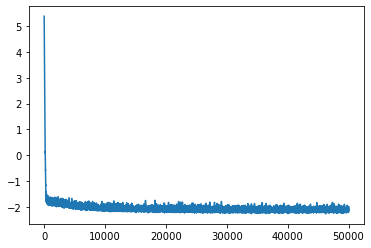

In [28]:
from matplotlib import pyplot as plt

plt.plot(loss_hist)

In [29]:
def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)
inv_map = hk.transform(inv_map_fn)

In [30]:
S_rec = inv_map.apply(params_final, None, X)

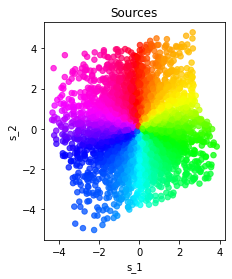

In [31]:
scatterplot_variables(S_rec, 'Sources', colors=colors, savefig=False)

In [32]:
from jax.scipy.stats import logistic

In [33]:
S_unif = logistic.cdf(S_rec) # use the Logistic cdf here!

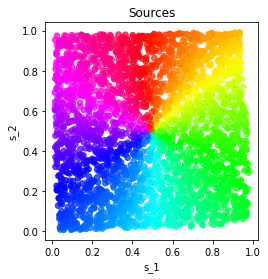

In [34]:
scatterplot_variables(S_unif, 'Sources', colors=colors, savefig=False)

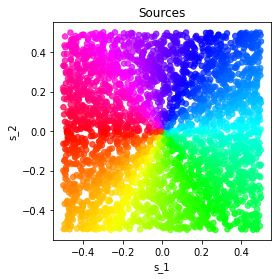

In [35]:
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

In [36]:
loss_final, _ = jax.value_and_grad(loss, 0)(params_final, X)
KL = jnp.mean(obs_likel) + loss_final

In [37]:
print(KL)

0.096185684


## Compute CIMA

In [38]:
# def cima(x):
#     jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
#     J = jac_fn(x)
#     detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
#     out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
#     return out

In [39]:
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
c = cima(X, jac_fn)

In [40]:
jnp.mean(c)

DeviceArray(0.00279775, dtype=float32)

In [41]:
c_hd = cima_higher_d(X, jac_fn)
jnp.mean(c_hd)

DeviceArray(0.00279776, dtype=float32)

In [42]:
# Check that the Jacobian is **not** triangular
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
J = jac_fn(X)
# J.shape
mean_J = np.mean(J, axis=0)
# mean_J.shape
print(mean_J)

[[ 13.731518  17.09001 ]
 [-19.00608   16.596222]]


In [43]:
# for i in range(2):
#     for j in range(2):
#         plt.plot(J[i,j])
#         plt.title(str(i)+","+str(j))
#         plt.show()

In [44]:
# Use the Amari distance for evaluation

## Amari distance evaluation

Rather than the average of the Amari distances between the products of the Jacobians, we should take the Amari distance of the average of the products of the Jacobians.
Otherwise it is hard to account for the fact that the Permutation matrix might be different at different locations

In [45]:
from metrics import jacobian_amari_distance

In [46]:
# Sample P a permutation matrix
Perm = np.array([[0,1],[1,0]])# a permutation matrix

def composed_function(x):
    y = unmixing_moebius(x)
    y = y @ Perm
    z = jnp.tanh(y)
    return z

In [47]:
jac_r_unmix = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_r_unmix = jax.jacfwd(unmixing_moebius)
# jac_r_unmix = jax.jacfwd(composed_function)
jac_t_mix = jax.jacfwd(mixing_moebius)

In [48]:
jac_r_unmix_vmap = jax.vmap(jac_r_unmix)
jac_t_mix_vmap = jax.vmap(jac_t_mix)

In [49]:
jad = jacobian_amari_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched)

In [50]:
print(jad)

0.022531746


In [51]:
# To do: Visualize the distortion from original sources to reconstructed ones?
# Maybe with a gridplot?

In [52]:
jac_fn = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_fn = jax.jacfwd(unmixing_moebius)
# jac_fn = jax.jacfwd(composed_function)

In [53]:
jac_fn_batched = vmap(jac_fn)

In [54]:
c_hd = cima_higher_d(X, jac_fn_batched)
jnp.mean(c_hd)

DeviceArray(0.00279776, dtype=float32)

In [55]:
c = cima(X, jac_fn_batched)
jnp.mean(c)

DeviceArray(0.00279775, dtype=float32)

In [56]:
jnp.mean(jacobian_amari_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched))

DeviceArray(0.02253175, dtype=float32)

## MCC based evaluation

In [57]:
from solve_hungarian import SolveHungarian

In [58]:
import numpy as np
from scipy.stats import spearmanr
from scipy.optimize import linear_sum_assignment

def SolveHungarian( recov, source, correlation='Pearson' ):
    """
    compute maximum correlations between true indep components and estimated components 
    """
    Ncomp = source.shape[1]
    if correlation == 'Pearson':
        CorMat = (np.abs(np.corrcoef( recov.T, source.T ) ) )[:Ncomp, Ncomp:]
    elif correlation == 'Spearman':
        rho, _ = np.abs(spearmanr( recov, source ) )
        CorMat = rho[:Ncomp, Ncomp:]
    ii = linear_sum_assignment( -1*CorMat )

    return CorMat[ii].mean(), CorMat, ii

In [59]:
av_corr_spearman, _, indices = SolveHungarian(recov=S_unif, source=S, correlation = 'Spearman')
print('Spearman correlation true-recovered sources: ', av_corr_spearman)

av_corr_pearson, _, indices = SolveHungarian(recov=S_unif, source=S, correlation = 'Pearson')
print('Pearson correlation true-recovered sources: ', av_corr_pearson)

Spearman correlation true-recovered sources:  0.9923666013182013
Pearson correlation true-recovered sources:  0.9922905557601516


In [60]:
# indices

In [61]:
# plt.plot(S_unif[:end, 1])
# plt.plot(S[:end, 0])
# plt.show()

In [62]:
indices[0]

array([0, 1])

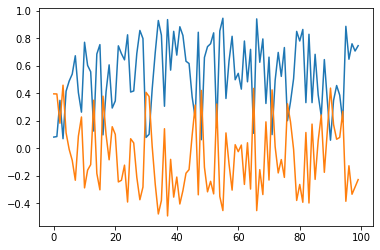

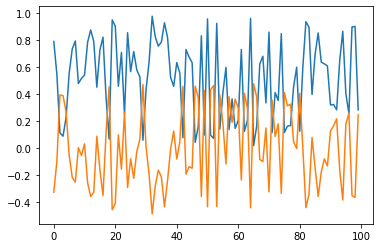

In [63]:
plt.figure()
end = 100
for i in range(S.shape[1]):
    plt.plot(S_unif[:end,indices[0][i]])
    plt.plot(S[:end, indices[1][i]])
    plt.show()

In [64]:
from metrics import jacobian_amari_inspired_distance

In [65]:
jacobian_amari_inspired_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched)

DeviceArray(0.02253175, dtype=float32)